## Build and track our portfolio based on our trades.

### Doesn't have any concept of buy and sell just yet.  only that a position is bought and held

In [111]:
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import pylab

Spoofing the data for now. Could come from xlsx or  pull from broker if there is an API

In [60]:
data = {'tickers': ['BTC-AUD', 'BOE.AX', 'PDN.AX', 'ETH-AUD', 'BOE.AX'] ,
        'prices': [10000, 0.34, 0.40, 300.0, 0.4 ],
        'amounts': [0.01, 3000, 2100, 0.11, -2000],  # negative amounts indicates a sell
        'dates': ['2021-01-01', '2021-01-01', '2021-01-01', '2021-01-01', '2021-05-01'],
        'type': ['crypto', 'equity', 'equity', 'crypto', 'equity' ],
         'commodity': [None, 'U', 'U', None, 'U']}  # Spoofing for now. Could come from xlsx or  pull from broker if there is an API

We load the data into a pandas dataframe

In [61]:
trade_data = pd.DataFrame.from_dict(data)

In [62]:
trade_data.head()

,tickers,prices,amounts,dates,type,commodity
0,BTC-AUD,10000.00,0.01,2021-01-01,crypto,None
1,BOE.AX,0.34,3000.00,2021-01-01,equity,U
2,PDN.AX,0.40,2100.00,2021-01-01,equity,U
3,ETH-AUD,300.00,0.11,2021-01-01,crypto,None
4,BOE.AX,0.40,-2000.00,2021-05-01,equity,U


lets look for duplicate tickers meaning we have either bought or sold the same ticker more than once

In [63]:
type(trade_data['tickers'].unique())

numpy.ndarray

So we wish to see how each trade has done on a daily basis.  We will use yfinance for now, could get from any number of APIs 

If you haven't already, `pip install yfinance` in a terminal

Lets define some constants which we will use to setup the scope of our analysis

In [64]:
PERIOD = '1D' # Daily
END = '2021-06-05' #  could use datetime.now

In [65]:
quotes = [] # empty list for storing quotes

for ticker, date in zip(trade_data['tickers'], trade_data['dates'] ):
    _quote = yf.Ticker(ticker)
    quotes.append(_quote.history(period=PERIOD, start=date, end=END))

In [66]:
quotes[0].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-12-31,37515.300781,38024.976562,36470.363281,37668.855469,60727639338,0,0
2021-01-01,37658.839844,38417.914062,37410.789062,38181.992188,52943282221,0,0
2021-01-02,38184.984375,43096.679688,37814.171875,41760.628906,88214867182,0,0
2021-01-03,41763.410156,44985.933594,41663.203125,42511.105469,102011582370,0,0
2021-01-04,42548.613281,43360.960938,37133.984375,41686.386719,105824510347,0,0


In [67]:
quotes[1].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04,0.097,0.1025,0.0970,0.100,7419529,0,0
2021-01-05,0.100,0.1100,0.0970,0.105,7129227,0,0
2021-01-06,0.105,0.1150,0.1000,0.110,10376936,0,0
2021-01-07,0.110,0.1150,0.1050,0.110,3905403,0,0
2021-01-08,0.110,0.1100,0.1025,0.110,6377449,0,0


----------
Lets open some candlestick charts [Helpful link](https://coderzcolumn.com/tutorials/data-science/candlestick-chart-in-python-mplfinance-plotly-bokeh)  Lets use Plotly for now.  `pip install plotly`

To use Plotly need to install [Node.js](https://nodejs.org/en/download/current/)    Do this by typing into a terminal

`conda install jodejs`   
followed by:   
`jupyter labextension install @jupyterlab/plotly-extension`   
----------------

Now lets make a little dropdown box for us to chose the ticker we want to see below in the plot    
`conda install ipywidgets`    
`jupyter labextension install @jupyter-widgets/jupyterlab-manager`


In [68]:
from ipywidgets import interact, interact_manual

In [69]:
@interact()
def make_plot(ticker=data['tickers']):

    ii = data['tickers'].index(ticker)
    candlestick = go.Candlestick(x=quotes[ii].index,
                                open=quotes[ii]['Open'],
                                high=quotes[ii]['High'],
                                low=quotes[ii]['Low'],
                                close=quotes[ii]['Close'])

    fig = go.Figure(data=[candlestick])
    fig.update_layout(xaxis_rangeslider_visible=False,
                     title=trade_data['tickers'][ii],
                     template='plotly_dark')

    fig.show()

interactive(children=(Dropdown(description='ticker', options=('BTC-AUD', 'BOE.AX', 'PDN.AX', 'ETH-AUD', 'BOE.A…

Now we need to generate our port folio based on the ticker data.  Dealing with datetimes is always painful

In [70]:
from datetime import datetime
_dates = []

for date in data['dates']:
    _dates.append(datetime.strptime(date, '%Y-%m-%d').date())


date_range = pd.date_range(start=min(_dates), end=END, freq='D')

In [71]:
date_range

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
               '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
               '2021-06-04', '2021-06-05'],
              dtype='datetime64[ns]', length=156, freq='D')

In [72]:
df = None
portfolio = date_range.to_frame()
frames = [portfolio]

for ii in range(len(data['tickers'])):
    print(ii)
    frames.append(quotes[ii]['Close'] * data['amounts'][ii])

df = pd.concat(frames, axis=1)
df = df.drop(df.columns[0], axis=1)

df.columns = data['tickers']

portfolio = df

0
1
2
3
4


In [73]:
portfolio.fillna(method='ffill', inplace=True)  ## forward fill.  so on weekends we carry forward Friday's value

In [74]:
portfolio['Total'] = portfolio.sum(axis=1)  # add to total as a column

In [75]:
portfolio

,BTC-AUD,BOE.AX,PDN.AX,ETH-AUD,BOE.AX,Total
2020-12-31,376.688555,NaN,NaN,105.412475,NaN,482.101030
2021-01-01,381.819922,NaN,NaN,104.430511,NaN,486.250433
2021-01-02,417.606289,NaN,NaN,110.745723,NaN,528.352012
2021-01-03,425.111055,NaN,NaN,139.152175,NaN,564.263230
2021-01-04,416.863867,300.000004,554.805297,149.193180,NaN,1420.862348
...,...,...,...,...,...,...
2021-06-01,473.003320,495.000020,1050.000000,373.512896,-330.000013,2061.516222
2021-06-02,485.198164,524.999991,1249.500060,384.378081,-349.999994,2294.076302
2021-06-03,511.663398,510.000005,1196.999985,409.844612,-340.000004,2288.507997
2021-06-04,476.592344,495.000020,1260.000050,381.979458,-330.000013,2283.571858


now lets merge duplicate columns wich represent multiple trades 

In [87]:
portfolio = portfolio.groupby(portfolio.columns, axis=1).sum()

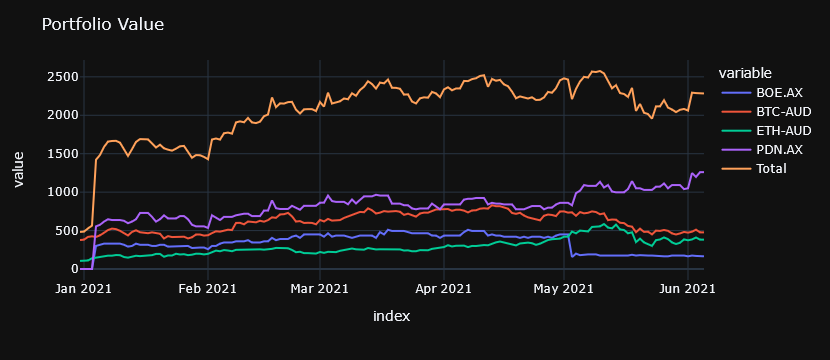

In [88]:
import plotly.express as px

fig = px.line(portfolio)
fig.update_layout(xaxis_rangeslider_visible=False,
                 title='Portfolio Value',
                 template='plotly_dark')
fig.show()

In [122]:
d = trade_data.groupby(['type']).sum()
# pylab.pie(d,  shadow = True, autopct='%1.1f%%', textprops={'color':"w"});
d

,prices,amounts
type,,
crypto,10300.00,0.12
equity,1.14,3100.00


In [127]:
portfolio.count()[0]-1

156

In [130]:
@interact()
def plot_pie(day=(0, portfolio.count()[0]-1)):
    vec = portfolio.iloc[day].to_numpy()[:-1]
    pylab.pie(vec, labels=portfolio.columns[:-1], shadow = True, autopct='%1.1f%%', textprops={'color':"w"});

interactive(children=(IntSlider(value=78, description='day', max=156), Output()), _dom_classes=('widget-intera…

In [38]:
portfolio.corr()

,BOE.AX,BTC-AUD,ETH-AUD,PDN.AX,Total
BOE.AX,1.000000,0.137931,0.835605,0.858449,0.912357
BTC-AUD,0.137931,1.000000,0.396568,0.365281,0.497547
ETH-AUD,0.835605,0.396568,1.000000,0.722587,0.886257
PDN.AX,0.858449,0.365281,0.722587,1.000000,0.939542
Total,0.912357,0.497547,0.886257,0.939542,1.000000


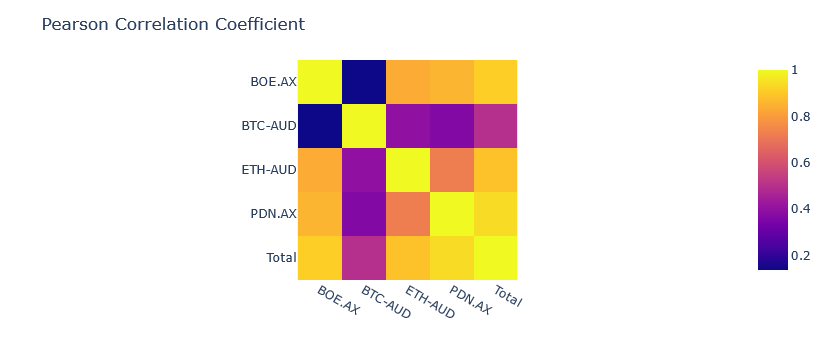

In [39]:
import plotly.express as px

fig = px.imshow(portfolio.corr())
fig.update_layout(
    title= 'Pearson Correlation Coefficient')
fig.show()